  asset                      time  AdrActCnt  BlkSizeMeanByte  CapMrktCurUSD  \
0   eos 2025-02-14 00:00:00+00:00       3944              NaN            NaN   
1   eos 2025-02-15 00:00:00+00:00       2159              NaN            NaN   
2   eos 2025-02-16 00:00:00+00:00       2116              NaN            NaN   
3   eos 2025-02-17 00:00:00+00:00       2241              NaN            NaN   
4   eos 2025-02-18 00:00:00+00:00       2582              NaN            NaN   

   CapRealUSD  FlowInExNtv  FlowInExNtv-status  FlowInExNtv-status-time  \
0         NaN          NaN                 NaN                      NaN   
1         NaN          NaN                 NaN                      NaN   
2         NaN          NaN                 NaN                      NaN   
3         NaN          NaN                 NaN                      NaN   
4         NaN          NaN                 NaN                      NaN   

   FlowOutExNtv  FlowOutExNtv-status  FlowOutExNtv-status-time  \
0 

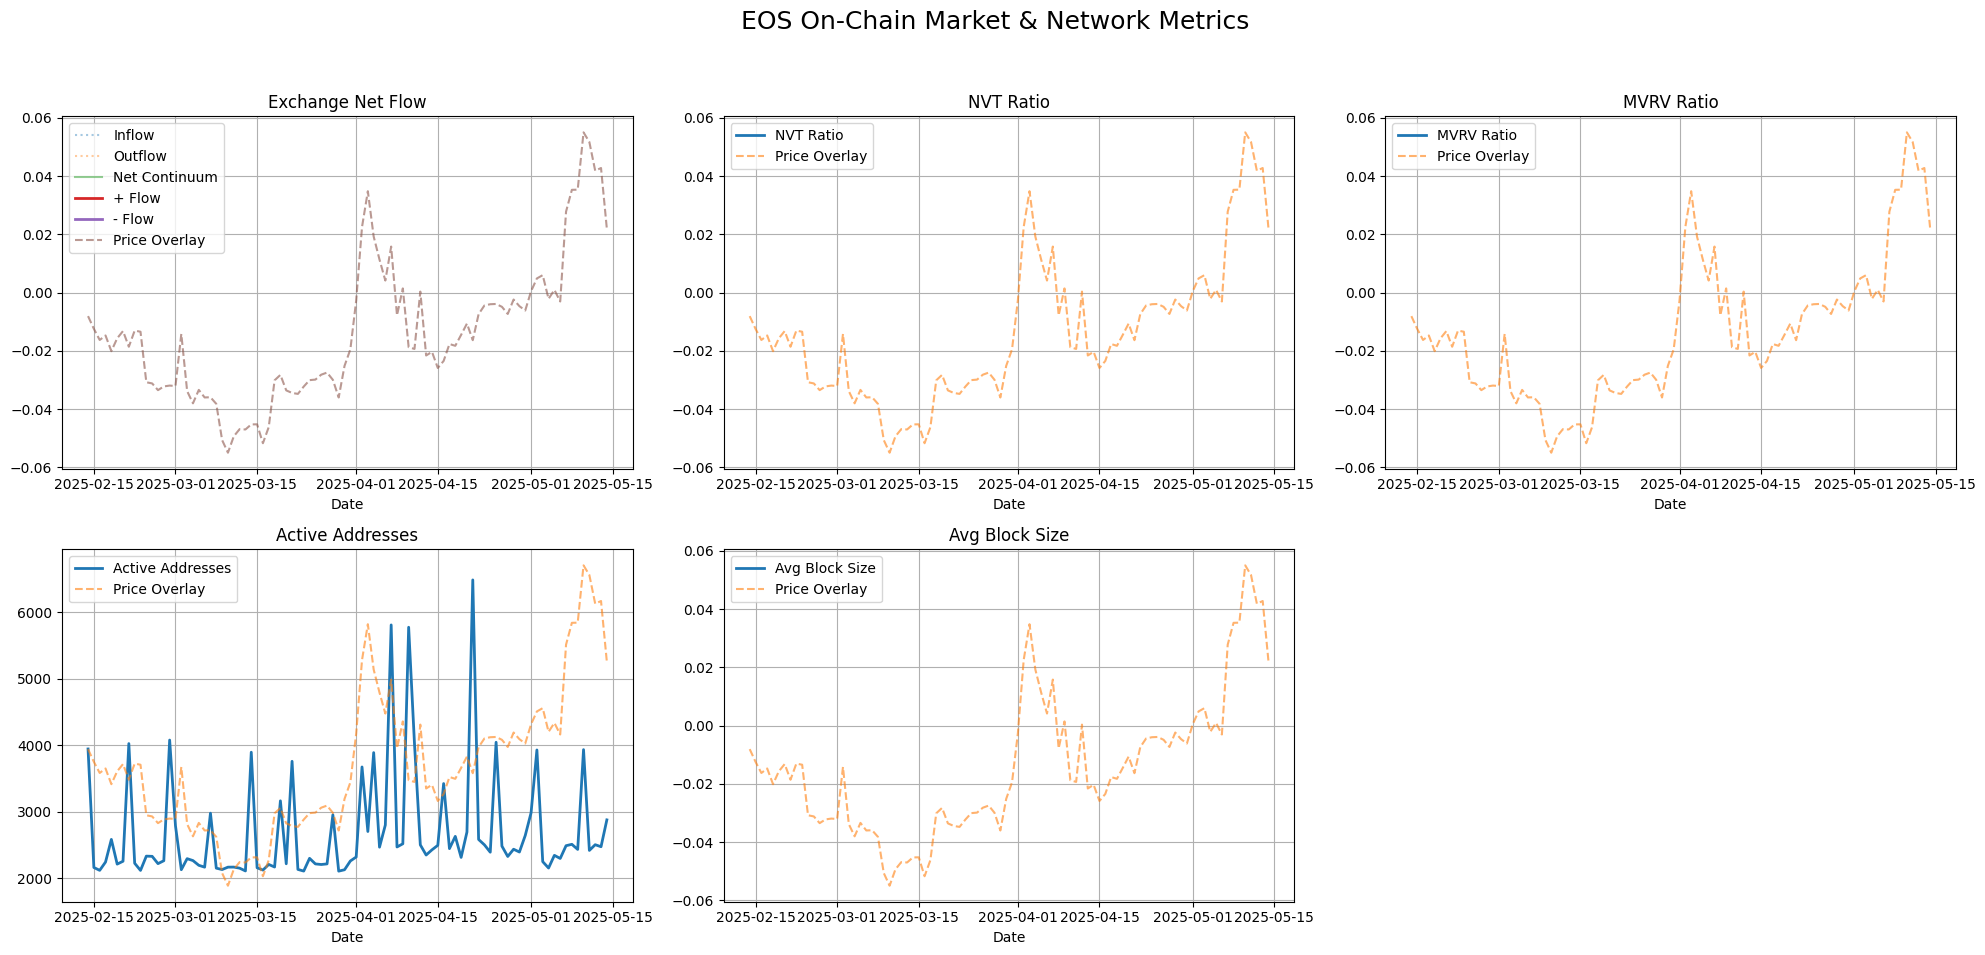

In [1]:
#!/usr/bin/env python3
import os         # For file existence checks
import requests
import pandas as pd
import numpy as np
import datetime
import io
import matplotlib.pyplot as plt

# ---------------------------------------------
# Configuration: change the asset and filenames
# ---------------------------------------------
# https://community-api.coinmetrics.io/v4/catalog-all/assets
ASSET = "eos" # doge neo
HISTORY_DAYS = 90  # lookback period in days

ONCHAIN_FILENAME = f"{ASSET}_onchain_daily.csv"
PRICE_FILENAME   = f"{ASSET}_price_daily.csv"
PLOT_FILENAME    = f"onchain-other-{ASSET.upper()}.png"

#########################
# Data Fetching Methods #
#########################

def fetch_coinmetrics_data(asset: str = ASSET, days: int = HISTORY_DAYS) -> pd.DataFrame:
    """
    Fetches daily on-chain metrics for the given asset from CoinMetrics Community API.
    Computes additional ratios and net flows.
    """
    metrics_list = [
        "AdrActCnt",          # Active Addresses
        "TxTfrValAdjNtv",     # Transaction Volume
        "CapMrktCurUSD",      # Market Cap
        "CapRealUSD",         # Realized Cap
        "FlowInExNtv",        # Exchange Inflows
        "FlowOutExNtv",       # Exchange Outflows
        "BlkSizeMeanByte"     # Avg Block Size
    ]
    end_date   = datetime.datetime.utcnow().strftime("%Y-%m-%d")
    start_date = (datetime.datetime.utcnow() - datetime.timedelta(days=days)).strftime("%Y-%m-%d")
    url = (
        "https://community-api.coinmetrics.io/v4/timeseries/asset-metrics"
        f"?assets={asset}&metrics={','.join(metrics_list)}"
        f"&start_time={start_date}&end_time={end_date}"
        "&frequency=1d&format=csv"
    )
    resp = requests.get(url, timeout=10)
    resp.raise_for_status()
    df = pd.read_csv(io.StringIO(resp.text))
    df['time'] = pd.to_datetime(df['time'])

    # Compute ratios and net flow
    df['NVT'] = np.where(df['TxTfrValAdjNtv'] > 0,
                         df['CapMrktCurUSD'] / df['TxTfrValAdjNtv'], np.nan)
    df['MVRV'] = np.where(df['CapRealUSD'] > 0,
                          df['CapMrktCurUSD'] / df['CapRealUSD'], np.nan)
    df['ExchNetFlow'] = df['FlowInExNtv'] - df['FlowOutExNtv']
    return df


def fetch_price_data(asset: str = ASSET, days: int = HISTORY_DAYS) -> pd.DataFrame:
    """
    Fetches daily PriceUSD data for the given asset.
    """
    end_date   = datetime.datetime.utcnow().strftime("%Y-%m-%d")
    start_date = (datetime.datetime.utcnow() - datetime.timedelta(days=days)).strftime("%Y-%m-%d")
    metric = "PriceUSD"
    url = (
        "https://community-api.coinmetrics.io/v4/timeseries/asset-metrics"
        f"?assets={asset}&metrics={metric}"
        f"&start_time={start_date}&end_time={end_date}"
        "&frequency=1d&format=csv"
    )
    resp = requests.get(url, timeout=10)
    resp.raise_for_status()
    df = pd.read_csv(io.StringIO(resp.text))
    df['time'] = pd.to_datetime(df['time'])
    return df


def store_data(df: pd.DataFrame, filename: str):
    """
    Append new rows to CSV if exists, else create file.
    """
    if os.path.exists(filename):
        old_df = pd.read_csv(filename)
        old_df['time'] = pd.to_datetime(old_df['time'])
        combined = pd.concat([old_df, df]).drop_duplicates(subset='time', keep='last')
        combined.sort_values('time', inplace=True)
        combined.to_csv(filename, index=False)
    else:
        df.to_csv(filename, index=False)
    print(f"Data saved to {filename}, rows: {len(df)}")

#############################################
# Plotting Figure: Additional Metrics Grid  #
#############################################

def plot_metrics(cm_df: pd.DataFrame, price_df: pd.DataFrame, filename: str = PLOT_FILENAME):
    """
    Plots on-chain metrics and overlays price.
    """
    cm_df = cm_df.sort_values('time')
    price_df = price_df.sort_values('time')

    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    fig.suptitle(f"{ASSET.upper()} On-Chain Market & Network Metrics", fontsize=18)

    def overlay_price(ax):
        y0, y1 = ax.get_ylim()
        p0, p1 = price_df['PriceUSD'].min(), price_df['PriceUSD'].max()
        scaled = y0 + (price_df['PriceUSD'] - p0) * (y1 - y0) / (p1 - p0)
        ax.plot(price_df['time'], scaled, '--', alpha=0.6, label="Price Overlay")

    metrics = [
        ("ExchNetFlow", "Exchange Net Flow", None),
        ("NVT",        "NVT Ratio",          "brown"),
        ("MVRV",       "MVRV Ratio",         "black"),
        ("AdrActCnt",  "Active Addresses",   "blue"),
        ("BlkSizeMeanByte", "Avg Block Size", "purple")
    ]

    for ax, (col, title, color) in zip(axes.flatten(), metrics):
        if col == "ExchNetFlow":
            t = cm_df['time']
            ax.plot(t, cm_df['FlowInExNtv'],  ':', linewidth=1.5, alpha=0.4, label='Inflow')
            ax.plot(t, cm_df['FlowOutExNtv'], ':', linewidth=1.5, alpha=0.4, label='Outflow')
            ax.plot(t, cm_df['ExchNetFlow'],  '-', linewidth=1.5, alpha=0.5, label='Net Continuum')
            ax.plot(t, cm_df['ExchNetFlow'].where(cm_df['ExchNetFlow']>=0), label='+ Flow', linewidth=2)
            ax.plot(t, cm_df['ExchNetFlow'].where(cm_df['ExchNetFlow']< 0), label='- Flow', linewidth=2)
        else:
            ax.plot(cm_df['time'], cm_df[col], linewidth=2, label=title)
        ax.set_title(title)
        overlay_price(ax)
        ax.set_xlabel('Date')
        ax.legend(loc='best')
        ax.grid(True)

    for ax in axes.flatten()[len(metrics):]:
        ax.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(filename)
    plt.show()
    plt.close()

#################
# Main Execution #
#################

def main():
    cm_df    = fetch_coinmetrics_data()
    price_df = fetch_price_data()
    if cm_df is not None:
        print(cm_df.head())
        store_data(cm_df, ONCHAIN_FILENAME)
    if price_df is not None:
        print(price_df.head())
        store_data(price_df, PRICE_FILENAME)
    if cm_df is not None and price_df is not None:
        plot_metrics(cm_df, price_df)

if __name__ == '__main__':
    main()
